# Human in the loop using persistence
here we incorporate human in the loop functionality using persistence

## 1. Import dependencies

In [1]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.sqlite import SqliteSaver                           # This is the tool that we will use to save the state permanently in the sqlite database as checkpoints
from langchain_ollama.chat_models import ChatOllama
from typing import TypedDict
import sqlite3

This is for graphing purpose

In [2]:
import nest_asyncio
nest_asyncio.apply()
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import Image

## 2. Linking the model

In [3]:
llm = ChatOllama(model="llama3.1:8b")

## 3. Create a state

In [4]:
class JokeState(TypedDict):                      # The JokeState inherits a TypedDict
    topic: str
    joke: str
    explanation: str

## 4. Define the function for the graph node

In [5]:
def generate_joke(state: JokeState):
    prompt = f'generate a joke on the topic {state["topic"]}'
    response = llm.invoke(prompt).content
    return {'joke': response}

In [6]:
def generate_explanation(state: JokeState):
    prompt = f'write an explanation for the joke - {state["joke"]}'
    response = llm.invoke(prompt).content    
    return {'explanation': response}

## 5. Create the graph

In [7]:
# Declare the graph:
graph = StateGraph(JokeState)                    # The StateGraph takes the state as a parameter, signifying that the "state" will be exchanged between the nodes through the edges.

# Add a nodes/states to the graph:
graph.add_node('generate_joke', generate_joke)
graph.add_node('generate_explanation', generate_explanation)

# Add the sequential edges:
graph.add_edge(START, 'generate_joke')
graph.add_edge('generate_joke', 'generate_explanation')
graph.add_edge('generate_explanation', END)

### Incorporate the checkpointer

In [8]:
conn = sqlite3.connect(database="persistence_3.db", check_same_thread=False)           # This will create the DB in case it didnot exist earlier.
checkpointer = SqliteSaver(conn)

## 6. Compile the graph while incorporating the checkpointer and breakpoint

In [9]:
workflow = graph.compile(checkpointer=checkpointer, interrupt_before=['generate_explanation'])

## 7. The Graph

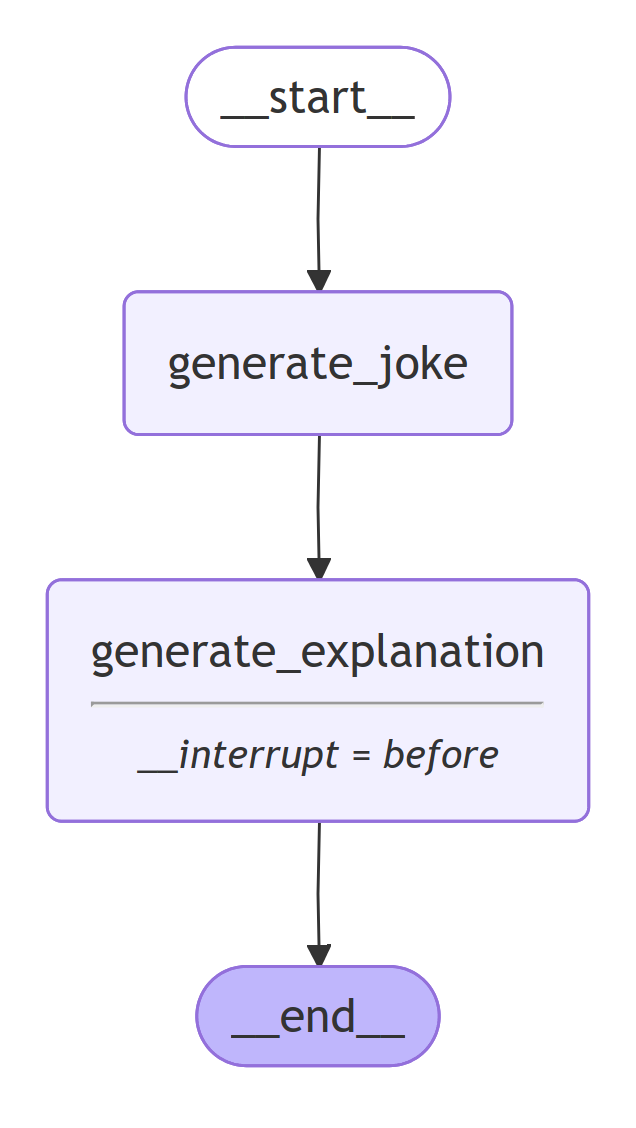

In [10]:
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER))

# 8. Incorporate the thread in config
To incorporate persistence, we are required to mention threads for each conversation, so that two different conversations do not pollute each other.

In [11]:
config1 = {"configurable": {"thread_id": "session_1"}}

## 9. Execute the code

In [12]:
final_state = workflow.invoke({'topic':'pizza'}, config=config1)
print(final_state)

{'topic': 'pizza', 'joke': "Here's one:\n\nWhy was the pizza in a bad mood?\n\nBecause it was feeling a little crusty!\n\nHope that made you laugh (or at least made your day a little more saucy)!"}


In [13]:
workflow.get_state(config1)

StateSnapshot(values={'topic': 'pizza', 'joke': "Here's one:\n\nWhy was the pizza in a bad mood?\n\nBecause it was feeling a little crusty!\n\nHope that made you laugh (or at least made your day a little more saucy)!"}, next=('generate_explanation',), config={'configurable': {'thread_id': 'session_1', 'checkpoint_ns': '', 'checkpoint_id': '1f0b26be-b1d4-6db6-8001-f7956724eb62'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}}, created_at='2025-10-26T13:01:42.429627+00:00', parent_config={'configurable': {'thread_id': 'session_1', 'checkpoint_ns': '', 'checkpoint_id': '1f0b26be-7b71-61ae-8000-213ea02f889e'}}, tasks=(PregelTask(id='b8b9dc48-b352-abc2-94df-6db489912032', name='generate_explanation', path=('__pregel_pull', 'generate_explanation'), error=None, interrupts=(), state=None, result=None),), interrupts=())

## 10. Ask the user for input and execute

In [17]:
human_choice = input("Shall I generate the explaination? (y/n)").strip().lower()
if human_choice == 'y':
    final_state = workflow.invoke(None, config=config1)
    print(final_state)
else:
    print("Operation canceled by the user")

{'topic': 'pizza', 'joke': "Here's one:\n\nWhy was the pizza in a bad mood?\n\nBecause it was feeling a little crusty!\n\nHope that made you laugh (or at least made your day a little more saucy)!", 'explanation': 'The joke relies on a play on words to create humor. The punchline "feeling a little crusty" has a double meaning here. Crusty is a term that can describe bread or pizza with a crispy texture, but it also sounds similar to "crusty" as in irritable or bad-tempered. This wordplay creates the pun and leads to the humorous effect of the joke.'}


In [18]:
workflow.get_state(config1)

StateSnapshot(values={'topic': 'pizza', 'joke': "Here's one:\n\nWhy was the pizza in a bad mood?\n\nBecause it was feeling a little crusty!\n\nHope that made you laugh (or at least made your day a little more saucy)!", 'explanation': 'The joke relies on a play on words to create humor. The punchline "feeling a little crusty" has a double meaning here. Crusty is a term that can describe bread or pizza with a crispy texture, but it also sounds similar to "crusty" as in irritable or bad-tempered. This wordplay creates the pun and leads to the humorous effect of the joke.'}, next=(), config={'configurable': {'thread_id': 'session_1', 'checkpoint_ns': '', 'checkpoint_id': '1f0b26bf-bf4d-6fcb-8002-0d1c5e7e9bb1'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}}, created_at='2025-10-26T13:02:10.685936+00:00', parent_config={'configurable': {'thread_id': 'session_1', 'checkpoint_ns': '', 'checkpoint_id': '1f0b26be-b1d4-6db6-8001-f7956724eb62'}}, tasks=(), interrupts=())

In [19]:
list(workflow.get_state_history(config1))

[StateSnapshot(values={'topic': 'pizza', 'joke': "Here's one:\n\nWhy was the pizza in a bad mood?\n\nBecause it was feeling a little crusty!\n\nHope that made you laugh (or at least made your day a little more saucy)!", 'explanation': 'The joke relies on a play on words to create humor. The punchline "feeling a little crusty" has a double meaning here. Crusty is a term that can describe bread or pizza with a crispy texture, but it also sounds similar to "crusty" as in irritable or bad-tempered. This wordplay creates the pun and leads to the humorous effect of the joke.'}, next=(), config={'configurable': {'thread_id': 'session_1', 'checkpoint_ns': '', 'checkpoint_id': '1f0b26bf-bf4d-6fcb-8002-0d1c5e7e9bb1'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}}, created_at='2025-10-26T13:02:10.685936+00:00', parent_config={'configurable': {'thread_id': 'session_1', 'checkpoint_ns': '', 'checkpoint_id': '1f0b26be-b1d4-6db6-8001-f7956724eb62'}}, tasks=(), interrupts=()),
 StateSnapshot(